# Lecture 6: Model Validation and Evaluation Metrics
***

<img src="figs/cogs.jpg" width=1100 height=50>

*Reminder: Scroll down to the bottom and shift-enter all of the Helper Functions*

<br>
<br>

### Problem 1: Building a ROC Curve 
***

Suppose you have the following table of data which has been classified using a Logistic Regression model.  Each row of the table contains the example's actual label, as well as the probability score assigned to it by Logistic Regression.  Note that they've been ordered according to their predicted probability of belonging to the positive class. 

$$
\begin{array}{|l|l|c|l|l|c|}
\hline 
\# & c & \hat{p}~(y=1 \mid x) & \# & c & \hat{p}~(y=1 \mid x) \\
\hline 
1  & P & 0.90& 11 & P & 0.40\\
2  & P & 0.80& 12 & N & 0.39\\
3  & N & 0.70& 13 & P & 0.38\\
4  & P & 0.60& 14 & N & 0.37\\
5  & P & 0.55& 15 & N & 0.36\\
6  & P & 0.54& 16 & N & 0.35\\
7  & N & 0.53& 17 & P & 0.34\\
8  & N & 0.52& 18 & P & 0.33\\
9  & P & 0.51& 19 & N & 0.30\\
10 & N & 0.50& 20 & N & 0.10\\
\hline 
\end{array}
$$


**Q**: The function below plots the ROC curve for the given data. Your job is to see if you can figure out how the plot was made from the given data.  See if you can do it without looking at the function, but then by all-means go ahead. 

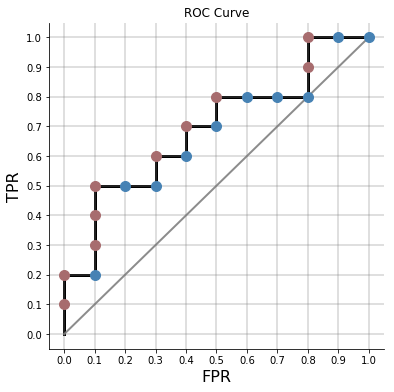

In [2]:
pred = [0.9, 0.8, 0.7, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.30, 0.10]
y = [1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0]
rocPlot(pred[:], y[:]) 

In the next part of this problem we'll see how we can use the convex hull of the ROC curve to identify the threshold parameter that gives the highest accuracy. The following function shows the convex hull 

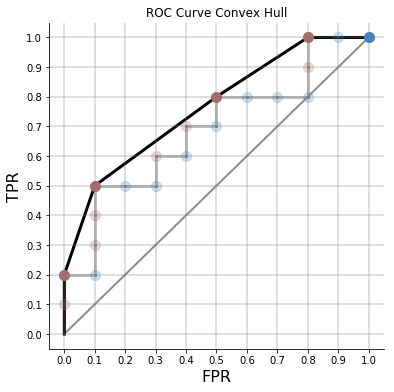

In [3]:
rochullPlot(pred, y)

The examples on the convex hull correspond to different thresholding parameters that have the potential to yield the highest accuracy.  Which one actually yields the highest accuracy depends on the balance of classes in the data set.  

**Q**: There exists a geometric notion of an **iso-accuracy** line.  "Iso" means not changing, so in ROC space, an iso-accuracy line is a line on which all models have the same accuracy.  Starting with the definition of of accuracy in terms of true positives (TP) and true negatives (TN), see if you can derive the equation of a line of the form $TPR = \beta \cdot FPR + \gamma$.  Note that you'll need quantities like the total number of data points ($N$), the total number of positive points in the set ($POS$) and the total number of negative points in the set ($NEG$).

**Hint**: The final form of the iso-accuracy line should look as follows: 

$$
TPR = \frac{NEG}{POS} FPR + \left( \frac{A - NEG/N}{POS/N} \right)
$$


 

**Q**: OK, so who cares?  What do iso-accuracy lines tell us? 

Note that this is an equation of the form $TPR = \beta \cdot FPR + \gamma$ in ROC space.  Notice that the slope of the line is given by the ratio of $NEG$ to $POS$ points in the data set.  Similarly, the accuracy $A$ appears in the intercept term of the iso-accuracy line.  

This line is called an iso-accuracy line because if we were to plug in a particular accuracy (say, 0.95) then this defines a distinct line in ROC space.  Furthermore, since $A$ does not affect the slope of the line, each iso-accuracy line is parallel to all the others. Finally, note that $A$ appears in the intercept term with a positive coefficient (i.e. 1), which means that if we plug in a higher accuracy we get a line that is shifted up higher in ROC space. 

The classifier on the convex hull of the ROC curve that yields the highest accuracy will be the point that lies on the iso-accuracy line corresponding to the highest accuracy.  Note that which point this is depends highly on the slope of the line, and thus on the ratio of $NEG$ to $POS$ points in the data set.  

For example, as in the concrete example case, the slope of the iso-accuracy lines are $NEG/POS = 1$, which means that the classifier with the highest accuracy on the convex hull is the point at $(0.1,0.5)$.

In [ ]:
rochullPlot(pred, y, iso=True)

On the other hand, if there had been 4 times as many $NEG$ examples as $POS$ examples, the slope of the iso-accuracy line would be $4$ and we'd find another classifier on the convex hull to have the highest accuracy. 

In [ ]:
rochullPlot(pred, y, fake_iso=4.0)

Or if there had been 2 times as many $POS$ examples as $NEG$ examples, the slope of the iso-accuracy line would be $0.5$ and we'd find yet another classifier on the convex hull to have the highest accuracy. 

In [ ]:
rochullPlot(pred, y, fake_iso=0.5)

Keep in mind though that these are accuracies using the standard definition of accuracy based on misclassification rate.  If you are trying to promote True Positives at the expense of False Positives, or trying hard to avoid False Positives at the expense of getting fewer True Positives, you may choose a classifier threshold different from the one that gives the highest misclassification accuracy. 

### Problem 2: Cross-Validation for Parameter Estimation in KNN

In this problem you will become comfortable with some commonly used features in sklearn.  These include 
- Error metrics for computing accuracy 
- Methods for dividing your data set into training, validation, and test sets
- Methods for performing cross-validation 
- Methods for performing a grid-search to find the best parameters of a model 

The first thing we'll do is import the MNIST data set from sklearns datasets module 

In [ ]:
from sklearn import datasets, metrics
digits = datasets.load_digits()

Next, we can visualize some of the training examples with matplotlib 

In [ ]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

Notice that this version of MNIST appears to be at a lower resolution than what you've seen in homework. In fact, if you look at a particular training example, you'll see that the images are only $8 \times 8$ pixels: 

In [ ]:
digits.images[0].shape

Next we'll use sklearns train_test_split routine to divide the data into training and validation sets. Notice that you can set the relative size of the test set as a parameter, as well as a random seed.  Further notice that we need to reshape the images into vectors so that we can store them as rows in a matrix. 

In [ ]:
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1230)
# X_train, X_test, y_train, y_test = train_test_split(digits.images.reshape((n_samples,-1)), digits.target, test_size=0.2, random_state=1230)

Check the relative sizes of the train and test matrices. 

In [ ]:
print(X_train.shape, X_test.shape)

So our training set is comprised of 1437 images and our validation set of 360 images. 

Next we'll fit a K Nearest Neighbors classifier to the data, starting with $K=3$. 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

To check the accuracy of the model on the training and validation data, we can use the KNeighborsClassifier's built in score function. 

In [ ]:
print("Accuracy on training data = {:.3f}".format(knn.score(X_train, y_train)))

In [ ]:
print("Accuracy on validation data = {:.3f}".format(knn.score(X_test, y_test)))

It looks like we're already doing pretty well, with a training set accuracy of $99.3\%$ and a validation set accuracy of $98.9\%$.  

Next we'll see how we can use cross-validation to get an estimate of the classifier accuracy.  Note that one of the parameters in cross_val_score is the number of folds in the cross-validation (cv)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X, y, cv=5)

If we want to see the scores across all of the folds we can just print the result from cross_val_score: 

In [ ]:
print(scores)

Note that the accuracies on the folds range from as low as $97.6\%$ to as high as $99.2\%$ accuracy.  We can then compute the mean of the scores over all folds  

In [ ]:
print("Mean Accuracy in Cross-Validation = {:.3f}".format(scores.mean()))

which gives a mean estimate of the generalization accuracy as $98.4\%$

The next thing we might want to do is explore the optimal choice of the parameter $K$ in the KNN algorithm.  One very convenient way to do this (especially when we have more parameters) is to use the built in GridSearchCV method.  GridSearchCV takes in a classifier and a range of parameters to test, gets accuracy estimates through cross-validation, and then returns the best parameters for the model.  Here's an example for KNN on MNIST data: 

In [ ]:
param_grid = dict(n_neighbors=np.array([2,3,4,5,6,8,9,10]))
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

From this object we might want to extract the parameter choice that gave the best accuracy as well as the associate score: 

In [ ]:
print("The optimal value of K was K = {:d}".format(grid.best_params_['n_neighbors']))

In [ ]:
print("Which had an assocated cross-validation accuracy of = {:.3f}".format(grid.best_score_))

If we want to see the results for each value of the parameter, we can print them as follows 

In [ ]:
print("searched parameters:")
print(grid.cv_results_['params'])
print("\nmean test score::")
print(grid.cv_results_['mean_test_score'])

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

### Helper Functions
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

def rocPlot(pred, y):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    colors = [mycolors["blue"] if yi==1 else mycolors["red"] for yi in y]
    
    pstep = 1.0/sum(y)
    nstep = 1.0/(len(y)-sum(y))
    
    cx = 0.0 
    cy = 0.0 
    for pi, yi in zip(pred, y):
        if yi == 1: 
            cxnew = cx 
            cynew = cy + pstep 
            plt.scatter([cxnew], [cynew], color=mycolors["red"], s=100, zorder=2)
        else: 
            cxnew = cx + nstep  
            cynew = cy 
            plt.scatter([cxnew], [cynew], color=mycolors["blue"], s=100, zorder=2)
        plt.plot([cx, cxnew], [cy, cynew], color="black", lw=3, zorder=1)
        cx = cxnew 
        cy = cynew 
        
    plt.plot([0,1],[0,1], color="gray", lw=2, alpha=0.9, zorder=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("ROC Curve")
    ax.set_xlabel("FPR", fontsize=16)
    ax.set_ylabel("TPR", fontsize=16)
    ax.set_xlim([-.05,1.05])
    ax.set_ylim([-.05,1.05])
    
    ax.set_xticks(np.arange(0,1.1,pstep))
    ax.set_yticks(np.arange(0,1.1,pstep))
    plt.grid(color="gray", linestyle="-", lw=2, alpha=0.25)
    
def rochullPlot(pred, y, iso=False, fake_iso=False):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    colors = [mycolors["blue"] if yi==0 else mycolors["red"] for yi in y]
    
    POS = sum(y)
    NEG = len(y) - POS
    
    pstep = 1.0/POS
    nstep = 1.0/NEG
    
    cx = 0.0 
    cy = 0.0 
    xpts = [0.0]
    ypts = [0.0]
    for pi, yi in zip(pred, y):
        if yi == 1: 
            cxnew = cx 
            cynew = cy + pstep 
            plt.scatter([cxnew], [cynew], color=mycolors["red"], s=100, zorder=2, alpha=0.25)
        else: 
            cxnew = cx + nstep  
            cynew = cy 
            plt.scatter([cxnew], [cynew], color=mycolors["blue"], s=100, zorder=2, alpha=0.25)
        xpts.append(cxnew)
        ypts.append(cynew)
        plt.plot([cx, cxnew], [cy, cynew], color="black", lw=3, zorder=1, alpha=0.25)
        cx = cxnew 
        cy = cynew 
        
    plt.plot([0,1],[0,1], color="gray", lw=2, alpha=0.9, zorder=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("ROC Curve Convex Hull")
    ax.set_xlabel("FPR", fontsize=16)
    ax.set_ylabel("TPR", fontsize=16)
    ax.set_xlim([-.05,1.05])
    ax.set_ylim([-.05,1.05])
    
    ax.set_xticks(np.arange(0,1.1,nstep))
    ax.set_yticks(np.arange(0,1.1,pstep))
    plt.grid(color="gray", linestyle="-", lw=2, alpha=0.25)

    rx = [xi for (xi, li) in zip(xpts, y) if li==1]
    ry = [yi for (yi, li) in zip(ypts, y) if li==1]
    
    xhull = [0.0]
    yhull = [0.0]
    
    cpx = xhull[0]
    cpy = yhull[0]

    ptsleft = [(x,y) for (x,y) in zip(xpts, ypts) if (x > cpx or y > cpy)]
    
    while not (cpx == xpts[-1] and cpy == ypts[-1]) and ptsleft:
        slopes = [1.0/nstep+1 if x==cpx else 1.0*(y-cpy)/(x-cpx) for x,y in ptsleft]
        mxslope = max(slopes)
        cpx = [x for ((x,y),s) in zip(ptsleft,slopes) if s==mxslope][-1]
        cpy = [y for ((x,y),s) in zip(ptsleft,slopes) if s==mxslope][-1]
        xhull.append(cpx)
        yhull.append(cpy)
        ptsleft = [(x,y) for (x,y) in zip(xpts, ypts) if (x > cpx or y > cpy)]
        
    plt.plot(xhull, yhull, color="black", lw=3, zorder=1)
    plt.scatter(xhull[1:-1], yhull[1:-1], color=mycolors["red"], s=100, zorder=2)
    plt.scatter([xhull[-1]], [yhull[-1]], color=colors[-1], s=100, zorder=2)
    
        
    # Compute intercepts of all points on convex hull 
    if iso: 
        intercepts = [y - (1.0*NEG/POS)*x for (x, y) in zip(xhull[1:], yhull[1:])]
        mxint = max(intercepts)
        mxind = 1 + np.argmax(np.array(intercepts))

        xplot = np.linspace(-0.5,1.5,50)
        plt.plot(xplot, (1.0*NEG/POS)*xplot + mxint, color=mycolors["blue"], lw=3)
    elif fake_iso: 
        NEG = fake_iso 
        POS = 1.0 
        intercepts = [y - (1.0*NEG/POS)*x for (x, y) in zip(xhull[1:], yhull[1:])]
        mxint = max(intercepts)
        mxind = 1 + np.argmax(np.array(intercepts))

        xplot = np.linspace(-0.5,1.5,50)
        plt.plot(xplot, (1.0*NEG/POS)*xplot + mxint, color=mycolors["blue"], lw=3)
  
    
from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")